In [100]:
%load_ext autoreload
%autoreload 3
from Probe import get_pdata, probe_shapelet
import numpy as np
import utils
import warnings
import torch
import pickle
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
from utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from tsai.models.FCN import FCN
model_path = 'models/GunPoint/'
model = FCN(c_in=1, c_out=2)
state_dict = torch.load(f'{model_path}/weight.pt',map_location='cuda:1')
model.load_state_dict(state_dict)
model.eval()

train_x, test_x, train_y, test_y, enc1 = read_UCR_UEA('GunPoint', None)

test_y = np.argmax(test_y, axis=1)
train_y = np.argmax(train_y, axis=1)
preds = np.load(f'{model_path}/test_preds.npy')

In [4]:
xai_name = 'DeepLift'
with open(f'attributions/GunPoint/{xai_name}/train_exp.pkl', 'rb') as f:
    attr = pickle.load(f)
attr_gp = attr['attributions']

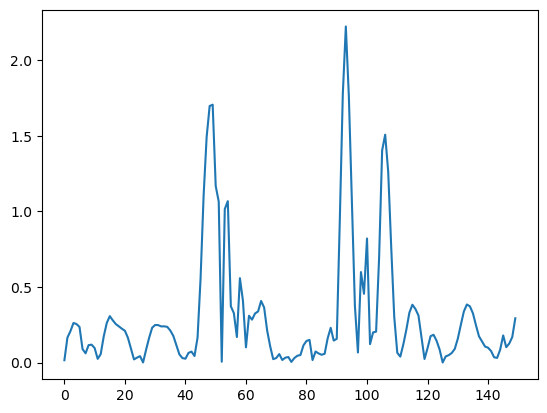

In [5]:
plt.plot(np.abs(attr_gp[2].flatten()))

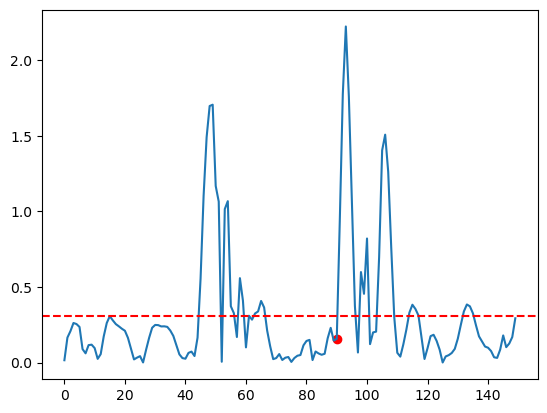

In [6]:
abs_attr = np.abs(attr_gp[2].flatten())
avg = np.mean(abs_attr)
plt.plot(np.abs(attr_gp[2].flatten()))
plt.axhline(avg,color='r',linestyle='--')
plt.scatter(90,abs_attr[90],color='r')

In [7]:
len(train_y[train_y==0])

24

In [8]:
len(train_y[train_y==1])

26

In [61]:
implets_class0 = implet_extractor(train_x, train_y, attr_gp, target_class=0)
implets_class1 = implet_extractor(train_x, train_y, attr_gp, target_class=1)

In [62]:
len(implets_class0)

31

In [63]:
len(implets_class1)

43

In [12]:
implets_class0[5]

[10,
 array([ 1.2757411 ,  1.226646  ,  1.1159707 ,  0.99977438,  0.85854875,
         0.70464193,  0.55480228,  0.39686227,  0.22281885,  0.07505256,
        -0.08004011, -0.2145043 , -0.33949792, -0.45934446, -0.54877228,
        -0.61674401, -0.65631161, -0.67350936, -0.67816246, -0.69404497,
        -0.68649434, -0.69951106, -0.69681154]),
 array([ 1.16853738,  2.53228545,  3.52209663,  3.12591457,  1.75206339,
        -0.50801766, -1.71957588, -2.39056253, -1.16398787, -0.23994525,
         0.03178047, -0.43247774, -1.33298886, -1.96645105, -2.26655674,
        -1.98417497, -1.18582594, -0.50324535, -0.11349499,  0.07682832,
         0.13113451,  0.15740803,  0.1235951 ]),
 3.3751359075631786,
 88,
 110]

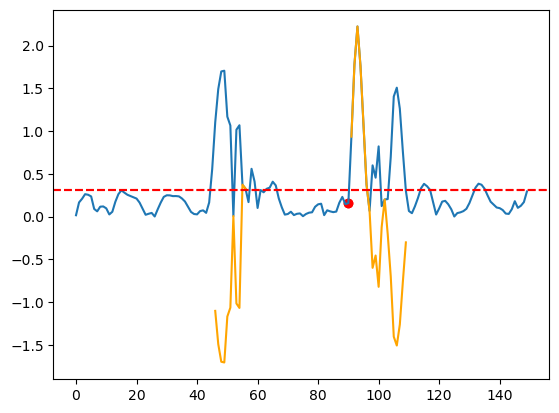

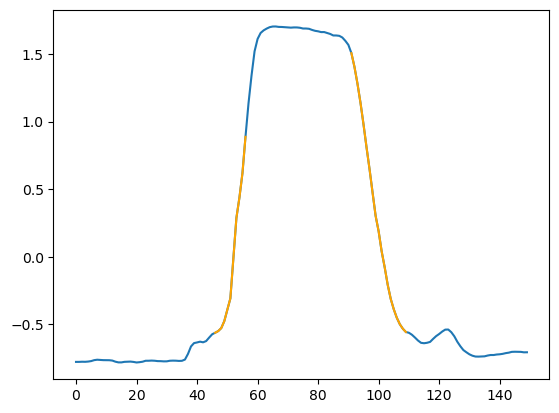

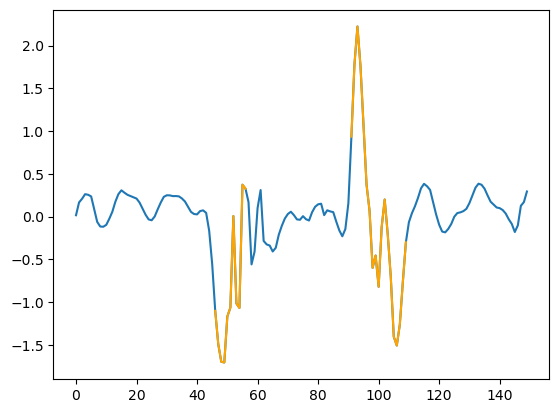

In [13]:
results = implets_class0[0:2]
plt.plot(np.abs(attr_gp[2].flatten()))
for result in results:
    _,sub_inst,sub_attr,max_score,best_start,best_end = result
    plt.plot(np.arange(best_start,best_end+1),sub_attr,color='orange')
    plt.axhline(avg,color='r',linestyle='--')
    plt.scatter(90,abs_attr[90],color='r')
plt.show()
plt.plot(train_x[2].flatten())
for result in results:
    _,sub_inst,sub_attr,max_score,best_start,best_end = result
    plt.plot(np.arange(best_start,best_end+1),sub_inst.flatten(),color='orange')
plt.show()

plt.plot(attr_gp[2].flatten())
for result in results:
    i,sub_inst,sub_attr,max_score,best_start,best_end = result
    plt.plot(np.arange(best_start,best_end+1),attr_gp[i,best_start:best_end+1],color='orange')
plt.show()

In [14]:
implets_class0[3]

[3,
 array([1.5142188 , 1.3992524 , 1.2610293 , 1.1175746 , 0.95725203]),
 array([1.2650739 , 2.12043643, 2.20449734, 1.49192369, 0.76352441]),
 1.3919890880584718,
 87,
 91]

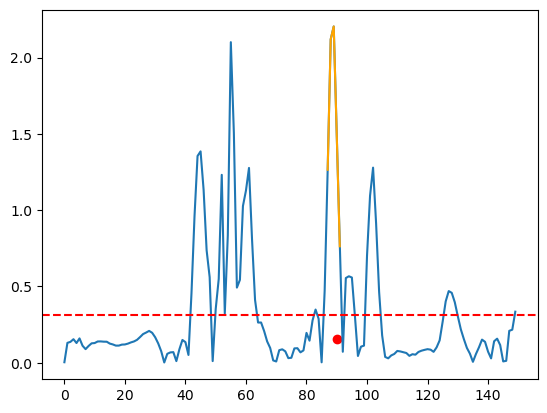

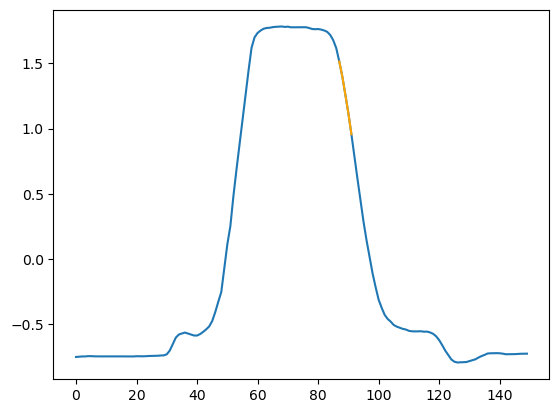

In [15]:
result = implets_class0[3]
i,sub_inst,sub_attr,max_score,best_start,best_end = result
plt.plot(np.abs(attr_gp[i].flatten()))
plt.plot(np.arange(best_start,best_end+1),sub_attr,color='orange')
plt.axhline(avg,color='r',linestyle='--')
plt.scatter(90,abs_attr[90],color='r')
plt.show()
plt.plot(train_x[i].flatten())
plt.plot(np.arange(best_start,best_end+1),sub_inst.flatten(),color='orange')
plt.show()

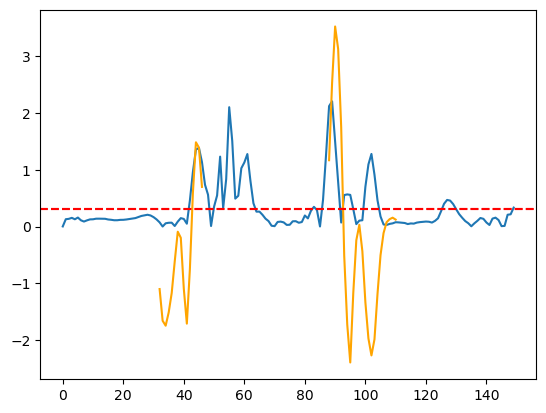

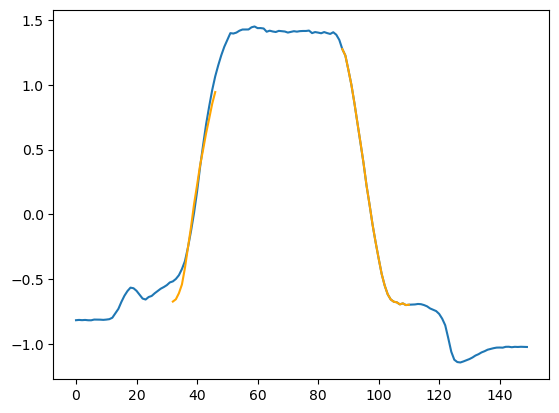

In [16]:
results = implets_class0[4:6]
plt.plot(np.abs(attr_gp[i].flatten()))
for result in results:
    i,sub_inst,sub_attr,max_score,best_start,best_end = result
    plt.plot(np.arange(best_start,best_end+1),sub_attr,color='orange')
    plt.axhline(avg,color='r',linestyle='--')
plt.show()
plt.plot(train_x[i].flatten())
for result in results:
    i,sub_inst,sub_attr,max_score,best_start,best_end = result
    plt.plot(np.arange(best_start,best_end+1),sub_inst.flatten(),color='orange')
plt.show()

In [67]:
# def plot_multiple_images_with_attribution(test_x, pred_y, n, shape, figsize=(12, 6), use_attribution=False,
#                                           attributions=None, normalize_attribution=True, title="", save_path=None,
#                                           test_y=None):


plot_multiple_images_with_attribution(
    np.array([imp[1] for imp in implets_class0]),
    np.array([0 for _ in implets_class0]),
    31,
    (8, 4),
    figsize=(24, 16),
    use_attribution=True,
    attributions=np.array([imp[2] for imp in implets_class0]),
    save_path='figure/implet_extract_gp.png'
)

In [83]:
from dtaidistance.clustering.kmeans import KMeans
from dtaidistance.dtw_barycenter import dba

implets_sub_class0 = [np.vstack((imp[1],imp[2])).T for imp in implets_class0]

k = 4
kmeans = KMeans(k=k)
assignment, _ = kmeans.fit(implets_sub_class0, use_c=True)

 10%|████████▍                                                                           | 1/10 [00:14<02:10, 14.54s/it]


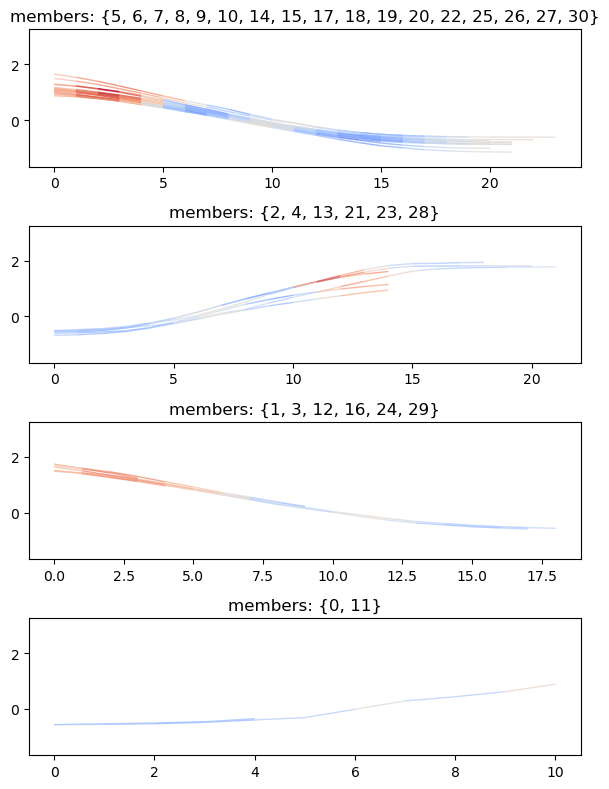

In [98]:
from matplotlib.collections import LineCollection
from matplotlib.colors import Normalize

fig, axs = plt.subplots(k, 1, figsize=(6, 8))

max_importance = max([np.max(np.abs(imp[:, 1])) for imp in implets_sub_class0])
norm = Normalize(vmin=-max_importance, vmax=max_importance)

ymin = min([np.min(imp[1]) for imp in implets_sub_class0])
ymax = max([np.max(imp[1]) for imp in implets_sub_class0])
# ymin -= (ymax - ymin) * 0.1
# ymax += (ymax - ymin) * 0.1

def plot(y, v, ax, alpha=1, lw=1):
    x = np.arange(len(y))
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = LineCollection(segments, cmap='coolwarm', norm=norm)
    lc.set_array(v)
    lc.set_alpha(alpha)
    lc.set_linewidths(lw)
    ax.add_collection(lc)

for i in range(k):
    members = assignment[i]
    for j in members:
        plot(implets_sub_class0[j][:, 0], implets_sub_class0[j][:, 1], axs[i], alpha=0.75)
    centroid = dba([implets_sub_class0[j] for j in members], None)
    # plot(centroid[:, 0], centroid[:, 1], axs[i], lw=3)
    axs[i].set_title(f'members: {str(members)}')
    axs[i].autoscale()
    axs[i].set_ylim(ymin, ymax)
    
plt.tight_layout()
# plt.show()
plt.savefig('figure/DTW_cluster_depDTW.png')

In [91]:
# 1d DTW clsutering

implets_sub_class0_1d = [imp[1] for imp in implets_class0]

k = 4
kmeans = KMeans(k=k)
assignment_1d, _ = kmeans.fit(implets_sub_class0_1d, use_c=True)

 10%|████████▍                                                                           | 1/10 [00:14<02:06, 14.06s/it]


[autoreload of utils.visualization failed: Traceback (most recent call last):
  File "/home/zwkan/miniconda3/envs/XAI2/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 274, in check
    superreload(m, reload, self.old_objects, self.shell)
  File "/home/zwkan/miniconda3/envs/XAI2/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "/home/zwkan/miniconda3/envs/XAI2/lib/python3.11/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 621, in _exec
  File "<frozen importlib._bootstrap_external>", line 936, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1074, in get_code
  File "<frozen importlib._bootstrap_external>", line 1004, in source_to_code
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/home/zwkan/Probe/implet/utils/visualization.py", 

(4,)
(22,)
(19,)
(11,)


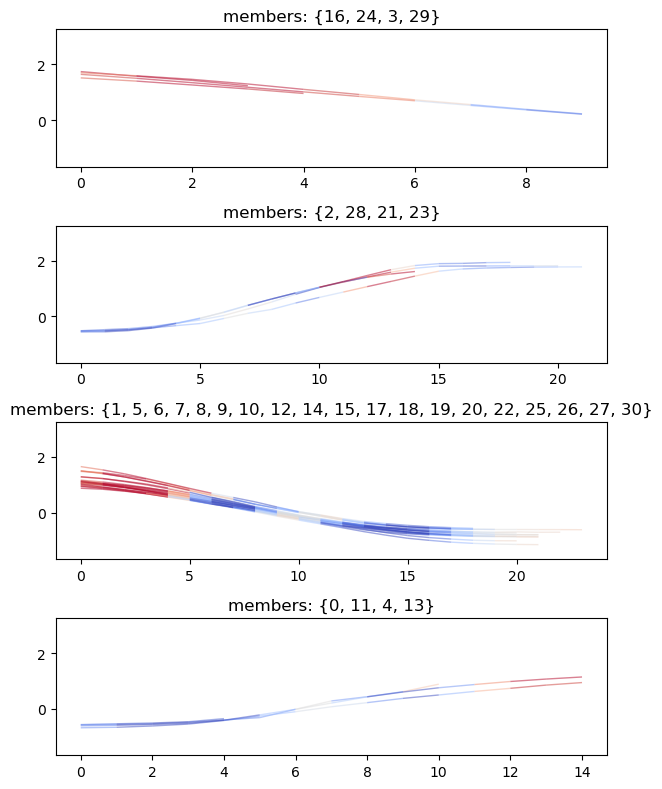

In [99]:
fig, axs = plt.subplots(k, 1, figsize=(6, 8))

max_importance = max([np.max(np.abs(imp[1])) for imp in implets_sub_class0_1d])
norm = Normalize(vmin=-max_importance, vmax=max_importance)
ymin = min([np.min(imp[1]) for imp in implets_sub_class0])
ymax = max([np.max(imp[1]) for imp in implets_sub_class0])

def plot(y, v, ax, alpha=1, lw=1):
    x = np.arange(len(y))
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = LineCollection(segments, cmap='coolwarm', norm=norm)
    lc.set_array(v)
    lc.set_alpha(alpha)
    lc.set_linewidths(lw)
    ax.add_collection(lc)


for i in range(k):
    members = assignment_1d[i]
    centroid = dba([implets_sub_class0_1d[j] for j in members], None)
    print(centroid.shape)
    # axs[i].plot(centroid, lw=3, c='gray')
    for j in members:
        plot(implets_sub_class0_1d[j], implets_class0[j][2], axs[i], alpha=0.5)
    axs[i].set_title(f'members: {str(members)}')
    axs[i].autoscale()
    axs[i].set_ylim(ymin, ymax)

plt.tight_layout()
# plt.show()
plt.savefig('figure/DTW_cluster_1dDTW.png')